## PDP

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


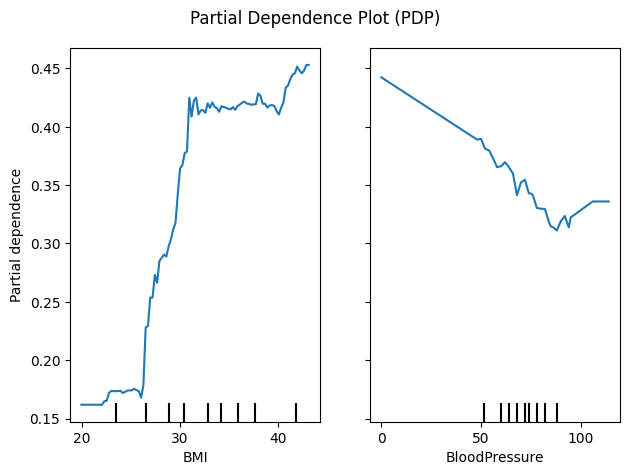

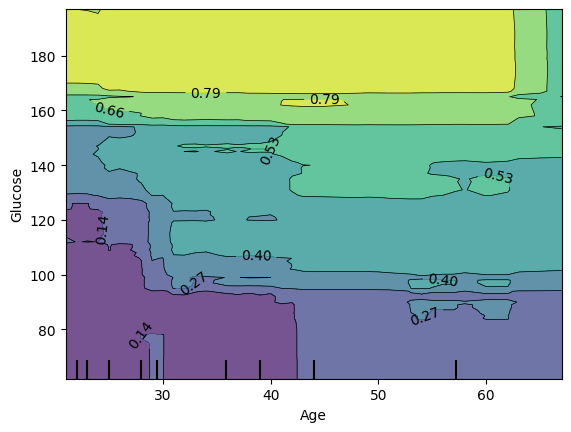

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay

# Load data from CSV
df = pd.read_csv("datasets/diabetes.csv")  # Replace with your path

# Inspect column names
print(df.columns)

# Separate features and target
X = df.drop(columns='Outcome') 
y = df['Outcome']              

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

# Choose 2 key features (edit as needed)
features = ['BMI', 'BloodPressure']  # Replace with valid columns from df

# PDP plot
PartialDependenceDisplay.from_estimator(model, X_test, features)
plt.suptitle("Partial Dependence Plot (PDP)")
plt.tight_layout()
plt.show()

PartialDependenceDisplay.from_estimator(model, X_test,features=[('Age','Glucose')])


## Gradcam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


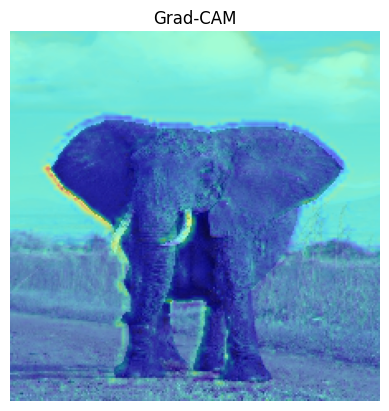

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam import Gradcam

# Build simple CNN (Functional API)
inp = Input(shape=(224, 224, 3))
x = Conv2D(16, 3, activation='relu')(inp)
x = MaxPooling2D()(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(2, activation='softmax')(x)
model = Model(inp, out)

# Load and preprocess image
img = load_img('datasets/elephant.jpg', target_size=(224, 224))
img_array = img_to_array(img) / 255.0
img_input = np.expand_dims(img_array, axis=0)

# Grad-CAM
score = CategoricalScore([np.argmax(model.predict(img_input))])
gradcam = Gradcam(model, model_modifier=ReplaceToLinear())
cam = gradcam(score, img_input, penultimate_layer=-1)[0]

# Display
plt.imshow(img_array)
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Grad-CAM')
plt.show()


## LRP

Epoch 1/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1539 - loss: 2.2362  
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6300 - loss: 1.8324
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6112 - loss: 1.2446
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6466 - loss: 0.7912
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6936 - loss: 0.6244


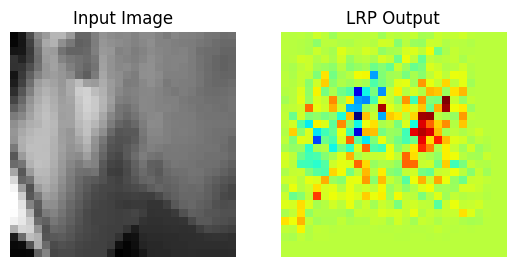

In [51]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load images using glob only
affected = glob.glob(r"E:\Xai_Req_Setup\Notebooks\datasets\image1\Affected\*.jpg")
not_affected = glob.glob(r"E:\Xai_Req_Setup\Notebooks\datasets\image1\Not affected\*.jpg")

# Load and preprocess images
images, labels = [], []
for path in affected:
    img = Image.open(path).convert('L').resize((28, 28))
    images.append(np.array(img) / 255.0)
    labels.append(1)
for path in not_affected:
    img = Image.open(path).convert('L').resize((28, 28))
    images.append(np.array(img) / 255.0)
    labels.append(0)

# Convert to NumPy arrays
x = np.array(images)[..., np.newaxis]  # Add channel dimension (28,28,1)
y = np.array(labels)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# CNN model
model = Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train with epoch logs
model.fit(x_train, y_train, epochs=5)

# LRP (Gradient × Input)
img = x_test[0]  # pick one image
img_tensor = tf.convert_to_tensor([img])  # batch with 1 image (needed for model input)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    preds = model(img_tensor)
    class_idx = tf.argmax(preds[0])
    loss = preds[0, class_idx]
grads = tape.gradient(loss, img_tensor)[0].numpy()
relevance = grads * img # Gradient × Input

# Display input and relevance map
plt.subplot(1, 2, 1)
plt.imshow(img.squeeze(), cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(relevance.squeeze(), cmap='jet')
plt.title("LRP Output")
plt.axis('off')
plt.show()


## Surrogate

A surrogate model is a model that is used to approximate the predictions of a more complex model. The purpose of using a surrogate model is typically to explain or interpret the behavior of a black-box model (like Random Forest in your case) using a simpler, interpretable model (like Decision Tree).

Random Forest Inference (Predictions):
[0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0]
0.7467532467532467


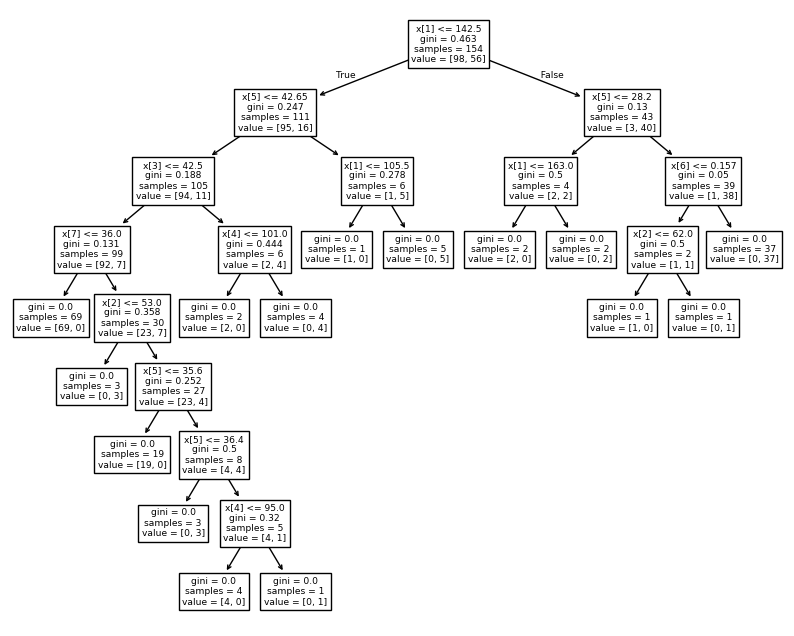

Surrogate Decision Tree Inference (Predictions):
[0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 0 0 1 0 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0]
Surrogate Decision Tree Accuracy: 0.7468


In [32]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('datasets/diabetes.csv')

# Features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Make predictions using Random Forest
y_pred_rf = rf_model.predict(X_test)

# Print inference (Random Forest predictions)
print("Random Forest Inference (Predictions):")
print(y_pred_rf)
print(accuracy_score(y_test,y_pred_rf))

# Train a simple Decision Tree as surrogate
dt_model = DecisionTreeClassifier()
dt_model.fit(X_test, y_pred_rf)

# Visualize Decision Tree
plt.figure(figsize=(10, 8))
plot_tree(dt_model)
plt.show()

# Evaluate surrogate Decision Tree
y_pred_dt = dt_model.predict(X_test)

# Print Decision Tree Inference
print("Surrogate Decision Tree Inference (Predictions):")
print(y_pred_dt)

# Evaluate accuracy of the surrogate model
print(f"Surrogate Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")


## Feature importance -sensitivity analysis

E:\Xai_Req_Setup\.jupyter_env\temp\ipykernel_3612\3135268712.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = le.fit_transform(X['Sex'])
E:\Xai_Req_Setup\.jupyter_env\temp\ipykernel_3612\3135268712.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['Age'].fillna(X['Age

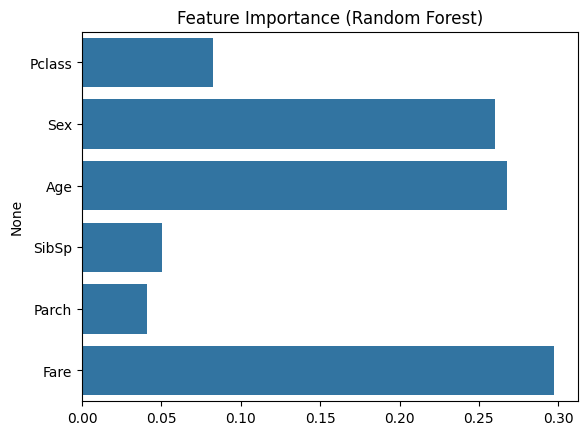

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load Titanic dataset
url = 'datasets/titanic.csv'
data = pd.read_csv(url)

# Preprocessing: Drop missing values and encode categorical features
data = data.dropna(subset=['Survived'])
X = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']

# Convert categorical variables into numeric using LabelEncoder
le = LabelEncoder()
X['Sex'] = le.fit_transform(X['Sex'])

# Fill missing Age with the median
X['Age'].fillna(X['Age'].median(), inplace=True)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
feature_importance = rf.feature_importances_

# Plot feature importance
sns.barplot(x=feature_importance, y=X.columns)
plt.title('Feature Importance (Random Forest)')
plt.show()


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Baseline Accuracy: 0.7208


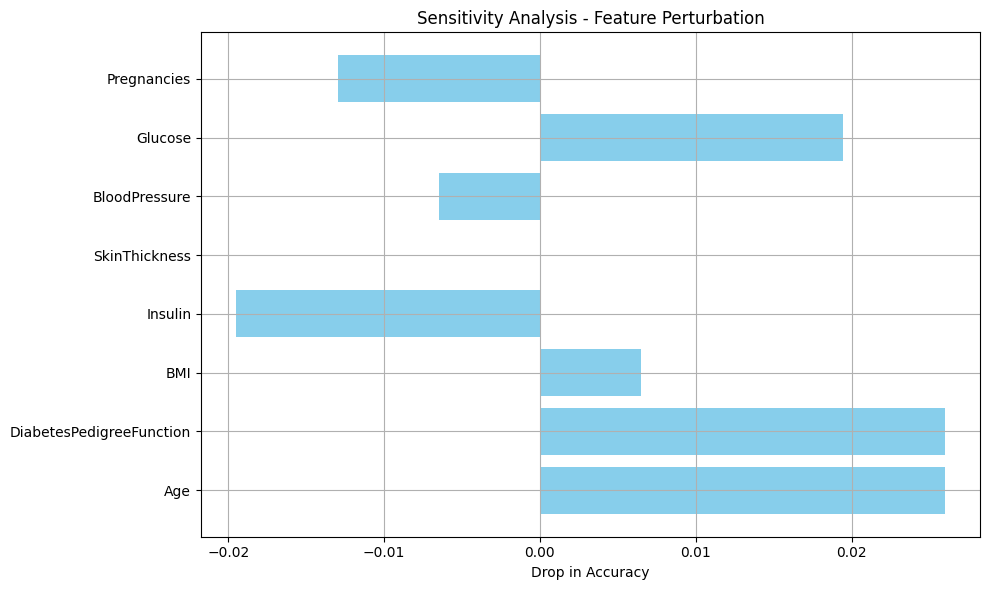

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load dataset
file_path = r'datasets\diabetes.csv'
df = pd.read_csv(file_path)

# Display first few rows
print(df.head())

# Split features and target
X = df.drop(columns=['Outcome'])  # Assuming 'Outcome' is the target
y = df['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Baseline accuracy
baseline_pred = model.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_pred)
print(f"Baseline Accuracy: {baseline_acc:.4f}")

# Sensitivity Analysis: Perturb one feature at a time
sensitivity = {}

for col in X.columns:
    X_test_perturbed = X_test.copy()
    X_test_perturbed[col] += X_test_perturbed[col].std()  # Add one std deviation

    perturbed_pred = model.predict(X_test_perturbed)
    perturbed_acc = accuracy_score(y_test, perturbed_pred)
    
    sensitivity[col] = baseline_acc - perturbed_acc

# Convert to DataFrame
sensitivity_df = pd.DataFrame(list(sensitivity.items()), columns=['Feature', 'Accuracy Drop'])

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sensitivity_df['Feature'], sensitivity_df['Accuracy Drop'], color='skyblue')
plt.xlabel('Drop in Accuracy')
plt.title('Sensitivity Analysis - Feature Perturbation')
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


Pregnancies: Accuracy drop = 0.0052
Glucose: Accuracy drop = 0.0052
BloodPressure: Accuracy drop = 0.0000
SkinThickness: Accuracy drop = 0.0052
Insulin: Accuracy drop = 0.0000
BMI: Accuracy drop = 0.0052
DiabetesPedigreeFunction: Accuracy drop = 0.0052
Age: Accuracy drop = 0.0052


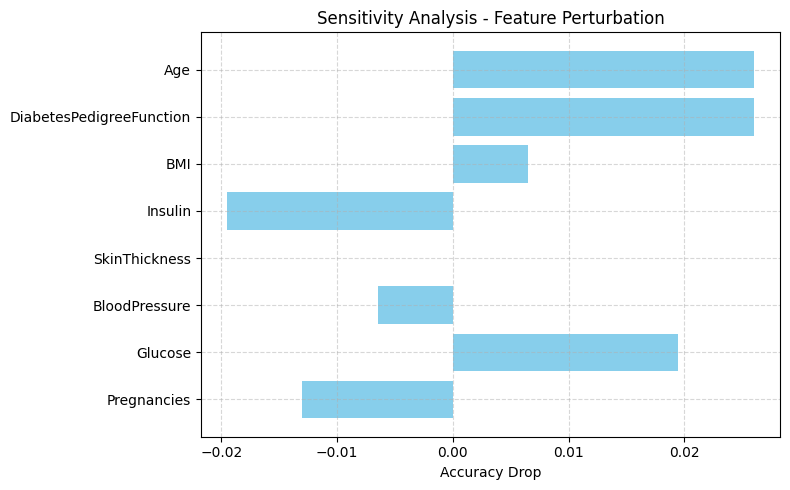

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv(r'datasets\diabetes.csv')

# Features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Baseline accuracy
baseline = accuracy_score(y_test, model.predict(X_test))

# Sensitivity Analysis
for col in X.columns:
    X_test_copy = X_test.copy()
    X_test_copy[col] += 0.01  # Small change
    new_acc = accuracy_score(y_test, model.predict(X_test_copy))
    print(f'{col}: Accuracy drop = {baseline - new_acc:.4f}')
plt.figure(figsize=(8, 5))
plt.barh(list(sensitivity.keys()), list(sensitivity.values()), color='skyblue')
plt.xlabel('Accuracy Drop')
plt.title('Sensitivity Analysis - Feature Perturbation')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()